In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, Activation, concatenate
from tensorflow import feature_column

import datetime
import os
import gc

import joblib

import efficientnet.tfkeras as efn

In [4]:
df_train = pd.read_csv('data/train.csv')

In [5]:
df_train.rename(columns={'age_approx':'age', 'anatom_site_general_challenge':'anatom'}, inplace = True)
df_train.dropna(axis=0, inplace = True)
df_train.isnull().sum()

image_name          0
patient_id          0
sex                 0
age                 0
anatom              0
diagnosis           0
benign_malignant    0
target              0
dtype: int64

In [6]:
df_train.head()

,image_name,patient_id,sex,age,anatom,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
Tabular_data = df_train.drop(['benign_malignant', 'patient_id', 'diagnosis'], axis = 1)
targets = df_train.target
Tabular_data.head()

,image_name,sex,age,anatom,target
0,ISIC_2637011,male,45.0,head/neck,0
1,ISIC_0015719,female,45.0,upper extremity,0
2,ISIC_0052212,female,50.0,lower extremity,0
3,ISIC_0068279,female,45.0,head/neck,0
4,ISIC_0074268,female,55.0,upper extremity,0


In [8]:
filenames = ['data/jpeg/train/' + fname + '.jpg' for fname in Tabular_data.image_name]

In [9]:
Tabular_data = Tabular_data.drop(['image_name'], axis = 1)

In [10]:
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [11]:
def create_df(image, tabular, target):
    image = process_image(image)

    return {'img_inp': image, 'tab_inp':  tabular}, target

In [12]:
X = filenames
#y = targets

In [13]:
feature_columns = []
feature_input = {}


age = feature_column.numeric_column('age')
feature_columns.append(age)
feature_input['age'] = tf.keras.Input(shape = (1,), name = 'age')

age_buckets = feature_column.bucketized_column(age, boundaries=[30, 45, 85])
feature_columns.append(age_buckets)
#feature_input['age_buckets'] = tf.keras.Input(shape = (3,), name = 'age_buckets')

sex = feature_column.categorical_column_with_vocabulary_list('sex', ['male', 'female'])
sex = feature_column.indicator_column(sex)
feature_columns.append(sex)
feature_input['sex'] = tf.keras.Input(shape = (1,), name = 'sex', dtype = tf.string)

anatom = feature_column.categorical_column_with_hash_bucket('anatom', hash_bucket_size=6)
anatom = feature_column.indicator_column(anatom)
feature_columns.append(anatom)
feature_input['anatom'] = tf.keras.Input(shape = (1,), name = 'anatom', dtype=tf.string)


feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
#feature_layer_outputs = feature_layer(feature_input)

In [14]:
feature_input

{'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'sex': <tf.Tensor 'sex:0' shape=(None, 1) dtype=string>,
 'anatom': <tf.Tensor 'anatom:0' shape=(None, 1) dtype=string>}

In [15]:
INPUT_SIZE = [IMG_SIZE,IMG_SIZE, 3]
HIDDEN_SIZE1 = 256
HIDDEN_SIZE2 = 128
HIDDEN_SIZE3 = 64
OUTPUT_SIZE = 2

In [16]:
Total_num_img = len(df_train)
Num_mlg = np.count_nonzero(df_train.target)
Num_bng = Total_num_img - Num_mlg

In [17]:
Weight_bng = 1/Num_bng * Total_num_img/2
Weight_mlg = 1/Num_mlg * Total_num_img/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

In [18]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [19]:
def create_model(retrain = False):
    model = []
    if retrain:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key=os.path.getctime)
        model = load_model(model_path)
        #model.summary()
    else:        
        img_inp = Input(shape = INPUT_SIZE, name = 'img_inp')
        #tab_inp = Input(shape = (), name = 'tab_inp', dtype = 'float32') 

        efnB3 = efn.EfficientNetB3(weights = 'imagenet', include_top = False)
        x1 = efnB3(img_inp)
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

        #x1 = Flatten()(x1)

        x2 = feature_layer(feature_input)
        x2 = Dense(50)(x2)
        x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)   

        concat = concatenate([x1, x2])
        #concat = x1
        concat = Dense(256, activation = 'relu')(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.2)(concat)

        
        concat = Dense(128, activation = 'relu')(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.2)(concat)

        
        concat = Dense(64, activation = 'relu')(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.2)(concat)


        outputs = Dense(OUTPUT_SIZE, activation= 'softmax')(concat)

        model = tf.keras.models.Model(inputs = [img_inp, feature_input], outputs = outputs)
        #model = tf.keras.models.Model(inputs = img_inp, outputs = outputs)

        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-3),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

        #model.summary()
    return model

In [20]:
#model = create_model(False)

In [21]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [23]:
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [24]:
tensorboard = create_tensorboard_callback()

In [25]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)
Rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0)

In [27]:
BATCH_SIZE = 45

def get_data(X, Tabular_data):

    x_train, x_val, tabular_train, tabular_val = train_test_split(X[:], Tabular_data[:], test_size = 0.2, random_state = 42)

    y_train = pd.get_dummies(tabular_train.target)
    tabular_train.drop('target', axis = 1, inplace = True)

    y_val = pd.get_dummies(tabular_val.target)
    tabular_val.drop('target', axis = 1, inplace = True)


    
    
    train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train),dict(tabular_train),tf.constant(y_train)))
    train_data = train_data.map(create_df).shuffle(buffer_size = len(x_train))
    train_data = train_data.batch(BATCH_SIZE)
    
    
    val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_val),dict(tabular_val),tf.constant(y_val)))
    val_data = val_data.map(create_df).batch(BATCH_SIZE)

    return train_data, val_data

In [28]:
def save_model_loop(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  
  model_path = "models/model" + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [29]:
folds = 5
kfolds = KFold(folds, shuffle = True, random_state = 42)

In [26]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
gc.collect()

165

In [30]:
targets_temp = Tabular_data.target
models = []
History = []
# Set number of images to use for experimenting
First_Image = 0
Last_Image = 30

for fold, (_, target_idx) in enumerate(kfolds.split(targets_temp)):
    X_fold = [X[i] for i in list(target_idx)]
    Tabular_fold = Tabular_data.iloc[target_idx]
    [train_data, val_data] = get_data(X_fold, Tabular_fold)
    if fold == 0:
        continue
        model = create_model(False)
    else:
        model = create_model(True)
        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-3/fold),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

    history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=[EarlyStopping, Rate,tensorboard], class_weight = class_weights)
    History.append(history)
    sfx = "EfficientNet3B_Img_Tab_fold{}".format(fold)
    save_model_loop(model, suffix=sfx)

    

Loading saved model from: models/model-EfficientNet3B_Img_Tab_fold0 - Copy.h5
Epoch 1/100
116/116 [==============================] - 2088s 18s/step - loss: 0.7571 - binary_accuracy: 0.5694 - auc: 0.6111 - val_loss: 0.8856 - val_binary_accuracy: 0.4939 - val_auc: 0.5076 - lr: 0.0010
Epoch 2/100
116/116 [==============================] - 2048s 18s/step - loss: 0.6262 - binary_accuracy: 0.5772 - auc: 0.6251 - val_loss: 0.8345 - val_binary_accuracy: 0.5407 - val_auc: 0.5665 - lr: 0.0010
Epoch 3/100
116/116 [==============================] - 2068s 18s/step - loss: 0.6186 - binary_accuracy: 0.6011 - auc: 0.6391 - val_loss: 0.9850 - val_binary_accuracy: 0.4186 - val_auc: 0.3960 - lr: 0.0010
Epoch 4/100
116/116 [==============================] - 2051s 18s/step - loss: 0.5943 - binary_accuracy: 0.6061 - auc: 0.6512 - val_loss: 0.8507 - val_binary_accuracy: 0.5108 - val_auc: 0.5381 - lr: 1.0000e-04
Epoch 5/100
116/116 [==============================] - 2045s 18s/step - loss: 0.5611 - binary_accu

In [31]:
#history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=[EarlyStopping, Rate,tensorboard], class_weight = class_weights)

In [32]:
#%tensorboard --logdir logs

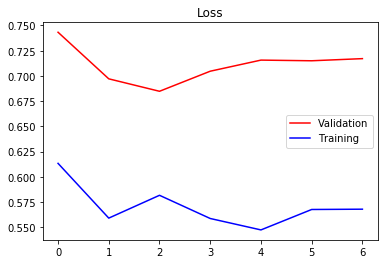

In [36]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

In [34]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [35]:
sfx = "EfficientNet3B_Img_Tab"
save_model(model, suffix=sfx)

Saving model to: models\20200719071746-EfficientNet3B_Img_Tab.h5...


'models\\20200719071746-EfficientNet3B_Img_Tab.h5'